In [2]:
import pandas as pd
import numpy as np

data=pd.read_csv('C:/Users/Nithin Das/Desktop/Neelima Assignment/data.csv')

print(data['apply'].value_counts())
import datetime as dt
data['search_date_pacific']=pd.to_datetime(data['search_date_pacific'],format='%Y-%m-%d').dt.date
data['city_match']=data['city_match'].astype('category')
Onehotenc=pd.get_dummies(data['city_match'],prefix='city_match',drop_first=True)
data=pd.concat([data,Onehotenc],axis=1)
data=data.drop('city_match',axis=1)
## user-interest weightage
user_item_interest=pd.pivot_table(data[['u_id','mgoc_id','apply']],index=['u_id','mgoc_id'],columns=['apply'],aggfunc=len).reset_index()
user_item_interest['Ratio']=user_item_interest[0]/user_item_interest[1]
user_item_interest=user_item_interest[user_item_interest[1]>=user_item_interest[0]].reset_index(drop=True)
user_item_interest['key']=user_item_interest['u_id'].map(str)+user_item_interest['mgoc_id'].map(str)
user_item_interest['User_Item_Weightage']=1
## user weightage
user=pd.pivot_table(data[['u_id','apply']],index=['u_id'],columns=['apply'],aggfunc=len).reset_index()
user['Ratio']=user[0]/user[1]
user=user[user[1]>=user[0]]
user['User_Weightage']=1
data['key']=data['u_id'].map(str)+data['mgoc_id'].map(str)
data=data.merge(user_item_interest[['key','User_Item_Weightage']],on='key',how='outer')
data=data.merge(user[['u_id','User_Weightage']],on='u_id',how='outer')
data=data.fillna(0)
#data['User_Item_Weightage']=data['User_Item_Weightage'].astype('category')
#data['User_Weightage']=data['User_Weightage'].astype('category')
#data['apply']=data['apply'].astype('category')
data_train=data[data['search_date_pacific']<dt.date(2018,1,27)]
data_test=data[data['search_date_pacific']>dt.date(2018,1,26)]

0    1092887
1     108003
Name: apply, dtype: int64


In [3]:
## Model evaluation 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

def ModelEvaluation(modelname,data_test,y_pred,y_pred_prob):
    metric_auc=roc_auc_score(data_test[y_features],y_pred)
    print(classification_report(data_test[y_features], y_pred))
    c_matrix = confusion_matrix(data_test[y_features], y_pred)
    print('Printing Confusion Matrix...')
    print(c_matrix)

    fpr, tpr, thresholds = roc_curve(np.array(data_test[y_features]), y_pred_prob)
    
    AUC_score=metrics.auc(fpr, tpr)
    print('AUC Score..')
    print(AUC_score)
    plt.figure()
    plt.plot(fpr, tpr, label=modelname+' (area = %0.2f)' % AUC_score)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
## Try Class Balancing techniques

from sklearn.utils import resample

data_apply0=data_train[data_train['apply']==0]
print(len(data_apply0))
data_apply1=data_train[data_train['apply']==1]
print(len(data_apply1))
## 1. Over sample minority
#data_oversample=resample(data_apply1,replace=True,n_samples=len(data_apply0),random_state=10)
#data_train=pd.concat([data_oversample,data_apply0],axis=0)

## 2.  Under sample Majority
#data_undersample=resample(data_apply0,replace=True,n_samples=len(data_apply1),random_state=10)
#data_train=pd.concat([data_undersample,data_apply1],axis=0)

## 3. Oversampling by SMOTE 
from imblearn.over_sampling import SMOTE 

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']



y_features=['apply']
sm = SMOTE(random_state=10)
X_res, y_res = sm.fit_sample(data_train[x_features], data_train[y_features])

print('SMOTE-d Shape..')
print(np.bincount(y_res))

x_train=pd.DataFrame(X_res,columns=x_features)
y_train=pd.DataFrame(y_res,columns=y_features)
data_train=pd.concat([x_train,y_train],axis=1)

986947
97417

C:\Users\Nithin Das\Anaconda2\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



SMOTE-d Shape..
[986947 986947]


             precision    recall  f1-score   support

          0       0.95      0.87      0.91    105940
          1       0.29      0.53      0.37     10586

avg / total       0.89      0.84      0.86    116526

Printing Confusion Matrix...
[[92147 13793]
 [ 4961  5625]]
AUC Score..
0.752030574147


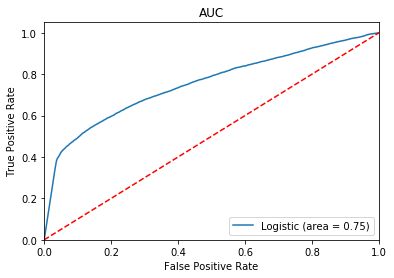

In [5]:
## SMOTE with Logistic
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

modelname='Logistic'
logreg = LogisticRegression(random_state=10)

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']

forest = logreg.fit(data_train[x_features], data_train[y_features])
y_pred=forest.predict(data_test[x_features])
y_pred_prob=forest.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

             precision    recall  f1-score   support

          0       0.92      0.62      0.74    105940
          1       0.11      0.45      0.17     10586

avg / total       0.85      0.61      0.69    116526

Printing Confusion Matrix...
[[65872 40068]
 [ 5771  4815]]


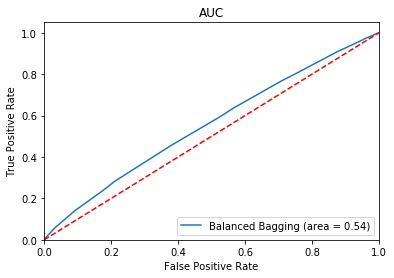

In [99]:
## 4. Class Balance using Ensemble Method: Bagging Algorithm on balanced dataset

## Dont run SMOTE if running this cell
from imblearn.ensemble import BalancedBaggingClassifier 
modelname='Balanced Bagging'
baggingclf = BalancedBaggingClassifier(random_state=42)
baggingclf.fit(data_train[x_features], data_train[y_features]) 
y_pred = baggingclf.predict(data_test[x_features])
y_pred_prob=baggingclf.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

In [ ]:
## 5. Cascade 
from imblearn.ensemble import BalanceCascade 
modelname='Cascading Classifier'
cc = BalanceCascade(random_state=10)
X_res, y_res = cc.fit_sample(data_train[x_features], data_train[y_features])

             precision    recall  f1-score   support

          0       0.95      0.83      0.88    105940
          1       0.24      0.55      0.34     10586

avg / total       0.88      0.80      0.83    116526

Printing Confusion Matrix...
[[87669 18271]
 [ 4730  5856]]
AUC Score..
0.736441079992


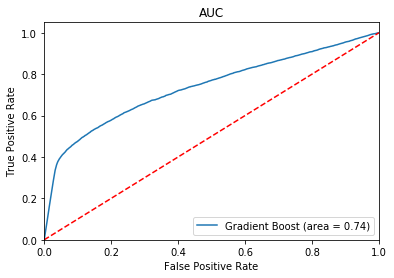

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

grd = GradientBoostingClassifier(learning_rate=0.5,min_samples_split=800,random_state=10,n_estimators=50)

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']
modelname='Gradient Boost'

grd.fit(data_train[x_features], data_train[y_features]) 
y_pred = grd.predict(data_test[x_features])
y_pred_prob=grd.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
 
modelname='K Nearest'

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']

neigh.fit(data_train[x_features], data_train[y_features]) 
y_pred = neigh.predict(data_test[x_features])
y_pred_prob=neigh.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

C:\Users\Nithin Das\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


             precision    recall  f1-score   support

          0       0.93      0.71      0.81    105940
          1       0.14      0.48      0.22     10586

avg / total       0.86      0.69      0.75    116526

Printing Confusion Matrix...
[[75536 30404]
 [ 5493  5093]]
AUC Score..
0.62746841667


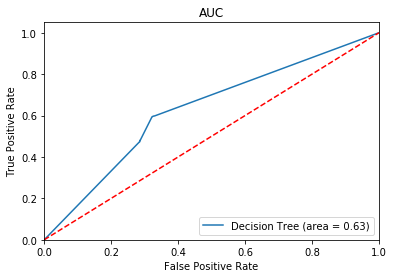

In [7]:
from sklearn import tree

modelname='Decision Tree'

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']

#dt = tree.DecisionTreeClassifier(criterion='gini')
## AUC Score 0.51
dt = tree.DecisionTreeClassifier(criterion='entropy')

dt.fit(data_train[x_features], data_train[y_features]) 
y_pred = dt.predict(data_test[x_features])
y_pred_prob=dt.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

In [ ]:
from sklearn import svm

modelname='SVM'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features=['apply']
vm = svm.SVC(kernel='linear')

vm.fit(data_train[x_features], data_train[y_features]) 
y_pred = vm.predict(data_test[x_features])
y_pred_prob=vm.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

             precision    recall  f1-score   support

          0       0.95      0.91      0.93    105940
          1       0.35      0.48      0.40     10586

avg / total       0.89      0.87      0.88    116526

Printing Confusion Matrix...
[[96675  9265]
 [ 5550  5036]]
AUC Score..
0.749082354809


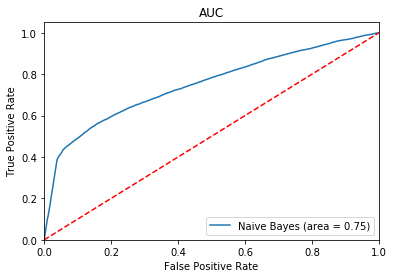

In [340]:
from sklearn.naive_bayes import GaussianNB
modelname='Naive Bayes'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']

nb = GaussianNB()

nb.fit(data_train[x_features], data_train[y_features]) 
y_pred = nb.predict(data_test[x_features])
y_pred_prob=nb.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

             precision    recall  f1-score   support

          0       0.95      0.88      0.91    105940
          1       0.30      0.51      0.38     10586

avg / total       0.89      0.85      0.87    116526

Printing Confusion Matrix...
[[93402 12538]
 [ 5139  5447]]
AUC Score..
0.754324515254


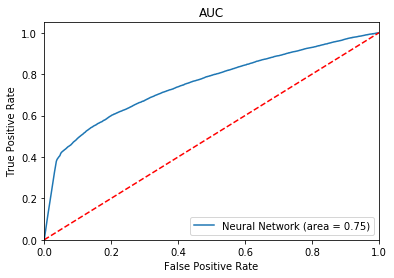

In [343]:
from sklearn.neural_network import MLPClassifier

modelname='Neural Network'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(data_train[x_features], data_train[y_features]) 
y_pred = nn.predict(data_test[x_features])
y_pred_prob=nn.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

In [ ]:
import xgboost as xgb


modelname='XGBoost'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.25)
gbm.fit(data_train[x_features], data_train[y_features])
y_pred = gbm.predict(data_test[x_features])
y_pred_prob=gbm.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
modelname='Random Forest'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']

forest = RandomForestClassifier(n_estimators = 100)
forest.fit(data_train[x_features], data_train[y_features])
predictions = gbm.predict(data_test[x_features])
y_pred = forest.predict(data_test[x_features])
y_pred_prob=forest.predict_proba(data_test[x_features])[:, 1]
ModelEvaluation(modelname,data_test,y_pred,y_pred_prob)

In [8]:
def AUCscore(data_test,predicted):
    
    metric_auc=roc_auc_score(data_test[y_features],predicted['Predicted Class'])
    print( 'AUC score..')
    print(metric_auc)

In [9]:
## Linear Regression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt




import statsmodels.api as sm

modelname='Linear Regression'
x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days','User_Item_Weightage','User_Weightage']


y_features=['apply']

lr = sm.OLS(data_train[y_features],data_train[x_features]).fit()
y_pred = lr.predict(data_test[x_features])
predicted=pd.DataFrame(y_pred,columns=['Predicted Value'])
predicted['Predicted Class']=np.where(predicted['Predicted Value']>0.5,1.0,0.0)
AUCscore(data_test,predicted)

C:\Users\Nithin Das\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


AUC score..
0.695920223657


In [156]:
from sklearn.linear_model import Lasso

lassoReg = Lasso(alpha=0.9, normalize=True)

lassoReg.fit(data_train[x_features],data_train[y_features])

y_pred = lassoReg.predict(data_test[x_features])
predicted=pd.DataFrame(y_pred,columns=['Predicted Value'])
predicted['Predicted Class']=np.where(predicted['Predicted Value']==0.5,1.0,0.0)
AUCscore(data_test,predicted)

AUC score..
0.5


In [175]:
from sklearn.linear_model import ElasticNet

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features=['apply']
ENreg = ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)

ENreg.fit(data_train[x_features],data_train[y_features])

y_pred = ENreg.predict(data_test[x_features])
predicted=pd.DataFrame(y_pred,columns=['Predicted Value'])
predicted['Predicted Class']=np.where(predicted['Predicted Value']>0.5,1.0,0.0)
AUCscore(data_test,predicted)

AUC score..
0.5


In [177]:
from sklearn.ensemble import GradientBoostingRegressor

x_features=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score',
       'city_match_0.0','city_match_1.0', 'job_age_days']

y_features=['apply']

alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(data_train[x_features],data_train[y_features])
y_pred = clf.predict(data_test[x_features])
predicted=pd.DataFrame(y_pred,columns=['Predicted Value'])
predicted['Predicted Class']=np.where(predicted['Predicted Value']>0.5,1.0,0.0)
AUCscore(data_test,predicted)

AUC score..
0.5
